C:\Users\lopec\AppData\Local\Temp\ipykernel_42140\1373546368.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bbva_data = yf.download(bbva_ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
C:\Users\lopec\AppData\Local\Temp\ipykernel_42140\1373546368.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  santander_data = yf.download(santander_ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


BBVA Data:
Price          Close      High       Low      Open    Volume
Ticker       BBVA.MC   BBVA.MC   BBVA.MC   BBVA.MC   BBVA.MC
Date                                                        
2000-01-03  4.115111  4.155740  4.106405  4.135426   8244257
2000-01-04  4.007733  4.088991  3.993223  4.062872   8522096
2000-01-05  3.917772  3.990323  3.900359  3.970008  12159826
2000-01-06  3.917772  3.917772  3.917772  3.917772         0
2000-01-07  3.967107  4.001931  3.926478  4.001931  62261944 

SANTANDER Data:
Price          Close      High       Low      Open   Volume
Ticker        SAN.MC    SAN.MC    SAN.MC    SAN.MC   SAN.MC
Date                                                       
2000-01-03  2.625065  2.661973  2.595077  2.652746  8797337
2000-01-04  2.562784  2.606612  2.539717  2.592772  8811013
2000-01-05  2.500502  2.546636  2.479741  2.514342  9333517
2000-01-06  2.500502  2.500502  2.500502  2.500502        0
2000-01-07  2.611227  2.618147  2.516651  2.518957  9603132 

✅

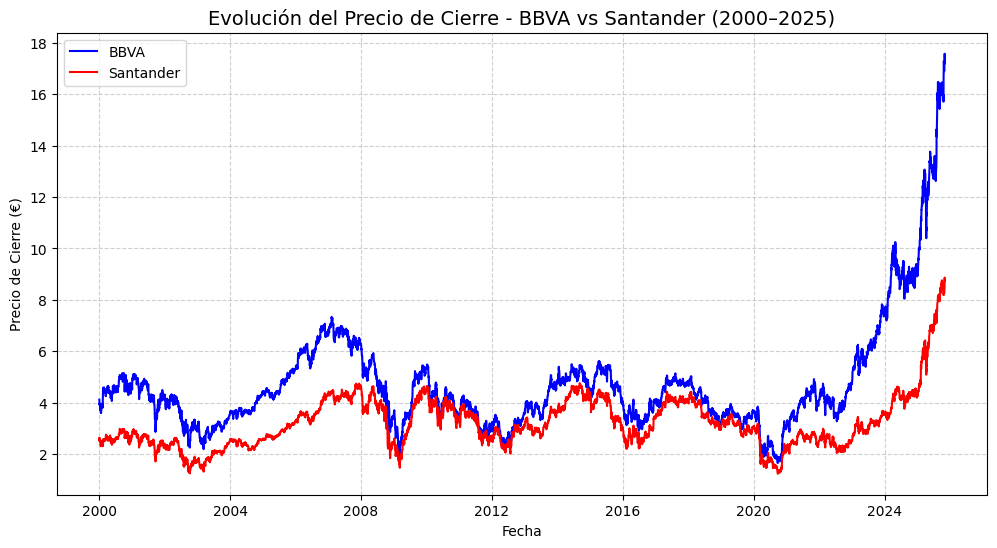

In [1]:
import yfinance as yf
import pandas as pd
import os

# ===========================================
# 1️⃣ Crear carpeta 'data' si no existe
# ===========================================
os.makedirs("../data", exist_ok=True)

# ===========================================
# 2️⃣ Definir símbolos y rango de fechas
# ===========================================
bbva_ticker = "BBVA.MC"       # Acción BBVA
santander_ticker = "SAN.MC"   # Acción Santander

start_date = "2000-01-01"
end_date = "2025-10-31"

# ===========================================
# 3️⃣ Descargar datos desde Yahoo Finance
# ===========================================
bbva_data = yf.download(bbva_ticker, start=start_date, end=end_date)
santander_data = yf.download(santander_ticker, start=start_date, end=end_date)

# Mostrar una vista rápida
print("BBVA Data:")
print(bbva_data.head(), "\n")
print("SANTANDER Data:")
print(santander_data.head(), "\n")

# ===========================================
# 4️⃣ Guardar los datos en carpeta /data
# ===========================================
bbva_data.to_csv("../data/BBVA.csv", index=True)
santander_data.to_csv("../data/SANTANDER.csv", index=True)

print("✅ Archivos guardados correctamente en la carpeta /data")

# ===========================================
# 5️⃣ Visualizar precios de cierre
# ===========================================
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(bbva_data.index, bbva_data['Close'], label='BBVA', color='blue')
plt.plot(santander_data.index, santander_data['Close'], label='Santander', color='red')
plt.title('Evolución del Precio de Cierre - BBVA vs Santander (2000–2025)', fontsize=14)
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre (€)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [4]:
import pandas as pd
from pathlib import Path

RAW_DIR = Path("../data/raw/precios")
OUT_DIR = Path("../data/interim/precios_limpios")
OUT_DIR.mkdir(parents=True, exist_ok=True)

def reparar_yahoo_web_csv(path_in: Path, nombre_out: str):
    # Leemos TODO como texto, sin header
    df_raw = pd.read_csv(path_in, header=None, dtype=str, engine="python")
    if df_raw.shape[1] < 6:
        raise ValueError(f"{path_in} no tiene 6 columnas esperadas")

    # Cabeceras reales del archivo Yahoo (2 primeras filas)
    header1 = df_raw.iloc[0].tolist()  # ['Price','Close','High','Low','Open','Volume']
    # header2 = df_raw.iloc[1].tolist()  # ['Ticker','BBVA.MC',... ]  (no la necesitamos)

    # Los datos empiezan en la fila 3 (index 2)
    data = df_raw.iloc[2:].copy()

    # Reconstruimos nombres: la 1ª columna es la fecha ("Date"), las demás vienen de header1[1:]
    cols = ['Date'] + header1[1:]
    data.columns = cols  # ahora hay 6 nombres para 6 columnas

    # Parseos
    data['Date'] = pd.to_datetime(data['Date'], errors="coerce")
    for c in ['Open','High','Low','Close','Volume','Adj Close']:
        if c in data.columns:
            data[c] = pd.to_numeric(
                data[c].str.replace(".","", regex=False).str.replace(",",".", regex=False),
                errors="coerce"
            )

    # Limpieza final
    data = (data
            .dropna(subset=['Date'])
            .drop_duplicates(subset=['Date'])
            .sort_values('Date')
            .reset_index(drop=True))

    # Guarda limpio
    out_path = OUT_DIR / f"{nombre_out}_core_clean.csv"
    data.to_csv(out_path, index=False)
    print(f"OK → {nombre_out}: {len(data)} filas → {out_path}")
    return data

# Ejecuta para ambos ficheros
bbva = reparar_yahoo_web_csv(RAW_DIR / "BBVA.csv", "BBVA")
san  = reparar_yahoo_web_csv(RAW_DIR / "SANTANDER.csv", "SAN")

# Calendario de trading (unión de fechas)
all_dates = sorted(set(bbva['Date'].dt.strftime("%Y-%m-%d")).union(
                   set(san['Date'].dt.strftime("%Y-%m-%d"))))
calendar_trading = pd.DataFrame({"date": all_dates})
print("Días trading en calendario:", len(calendar_trading))
calendar_trading.head()


C:\Users\lopec\AppData\Local\Temp\ipykernel_42140\2127674686.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Date'] = pd.to_datetime(data['Date'], errors="coerce")


OK → BBVA: 6634 filas → ..\data\interim\precios_limpios\BBVA_core_clean.csv
OK → SAN: 6634 filas → ..\data\interim\precios_limpios\SAN_core_clean.csv
Días trading en calendario: 6634


C:\Users\lopec\AppData\Local\Temp\ipykernel_42140\2127674686.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Date'] = pd.to_datetime(data['Date'], errors="coerce")


,date
0,2000-01-03
1,2000-01-04
2,2000-01-05
3,2000-01-06
4,2000-01-07
